In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Data
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Load and preprocess the dataset
def load_data(file_path):
    data = pd.read_csv(file_path)

    X = data.drop(['target'], axis=1)
    y = data['target']  # Assuming 'target' column for labels

    # Scale features and encode labels
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor

# Create a graph with k-nearest neighbors edges and proper batching
def create_graph_data(X, y, k=5):
    from sklearn.neighbors import kneighbors_graph
    edge_matrix = kneighbors_graph(X.numpy(), k, mode="connectivity", include_self=False)
    edge_index = torch.tensor(np.array(edge_matrix.nonzero()), dtype=torch.long)
    batch = torch.arange(X.size(0), dtype=torch.long)  # Each node treated as separate graph
    return Data(x=X, edge_index=edge_index, y=y, batch=batch)

# Define a custom GraphSAGE model with mean pooling
class CustomGraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim // 2)
        self.fc = torch.nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Mean pooling for global representation
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Load data and initialize the model
file_path = 'Dataset.csv'
X, y = load_data(file_path)
data = create_graph_data(X, y)
train_indices, test_indices = train_test_split(range(len(y)), test_size=0.2, random_state=42)
data.train_mask = torch.tensor(train_indices, dtype=torch.long)
data.test_mask = torch.tensor(test_indices, dtype=torch.long)

input_dim = X.size(1)
hidden_dim = 128  # Reduce hidden dimensions for faster computation
output_dim = len(torch.unique(y))

# Initialize model, optimizer, and criterion
model = CustomGraphSAGE(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop with mini-batch processing
epochs = 100  # Reduce epochs for faster training
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(data).argmax(dim=1)
    y_true = data.y[data.test_mask].numpy()
    y_pred = predictions[data.test_mask].numpy()
    report = classification_report(y_true, y_pred, output_dict=True)

print(f"Classification Report: {report}")


Epoch 0, Loss: 0.7025
Epoch 10, Loss: 0.2194
Epoch 20, Loss: 0.1808
Epoch 30, Loss: 0.1549
Epoch 40, Loss: 0.1307
Epoch 50, Loss: 0.1201
Epoch 60, Loss: 0.1123
Epoch 70, Loss: 0.1385
Epoch 80, Loss: 0.0988
Epoch 90, Loss: 0.0937
Classification Report: {'0': {'precision': 0.976028832453273, 'recall': 0.8514294070337062, 'f1-score': 0.9094814120587317, 'support': 13677.0}, '1': {'precision': 0.964254929899555, 'recall': 0.9948095315874486, 'f1-score': 0.9792939579090292, 'support': 55101.0}, 'accuracy': 0.9662973625287156, 'macro avg': {'precision': 0.970141881176414, 'recall': 0.9231194693105773, 'f1-score': 0.9443876849838804, 'support': 68778.0}, 'weighted avg': {'precision': 0.9665962551085928, 'recall': 0.9662973625287156, 'f1-score': 0.9654112310255125, 'support': 68778.0}}


Classification Report:
{'0': {'precision': 0.976028832453273, 'recall': 0.8514294070337062, 'f1-score': 0.9094814120587317, 'support': 13677.0}, '1': {'precision': 0.964254929899555, 'recall': 0.9948095315874486, 'f1-score': 0.9792939579090292, 'support': 55101.0}, 'accuracy': 0.9662973625287156, 'macro avg': {'precision': 0.970141881176414, 'recall': 0.9231194693105773, 'f1-score': 0.9443876849838804, 'support': 68778.0}, 'weighted avg': {'precision': 0.9665962551085928, 'recall': 0.9662973625287156, 'f1-score': 0.9654112310255125, 'support': 68778.0}}


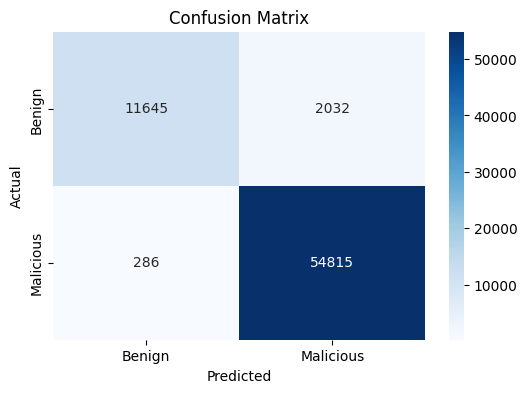

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(data).argmax(dim=1)
    y_true = data.y[data.test_mask].numpy()
    y_pred = predictions[data.test_mask].numpy()
    report = classification_report(y_true, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)

# Print classification report
print(f"Classification Report:\n{report}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
